### Import libraries

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

### Customize

In [8]:
# Customize parameters
my_input_file="0904 Transaction_data.csv"
my_plot_file="0905 alert_scatter_plot.png"
my_output_file="0905 alert_transactions.csv"
my_high_alert_amount=1000
my_mid_alert_amount=500

### Prepare data and inline customization

In [9]:
# Load the cleaned transaction dataset
df = pd.read_csv(my_input_file)

# Clean numeric fields and drop any invalid rows
df["TransactionAmount"] = pd.to_numeric(df["TransactionAmount"], errors='coerce')
df["TransactionHour"] = pd.to_numeric(df["TransactionHour"], errors='coerce')
df = df.dropna(subset=["TransactionAmount", "TransactionHour"]).copy()

# Create a TransactionID if not already present
df["TransactionID"] = ["T" + str(i).zfill(5) for i in range(len(df))]

# Define which features to use in the anomaly detection model
numeric_features = ["TransactionAmount", "TransactionHour"]
categorical_features = ["MerchantCategory", "DeviceID"]

# Preprocessing pipeline for standardizing numeric and one-hot encoding categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop='first'), categorical_features)
    ]
)


### Use Isolation forest

In [10]:
# Create and fit the Isolation Forest model pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("isoforest", IsolationForest(n_estimators=100, contamination=0.02, random_state=42))
])
pipeline.fit(df)

# Generate anomaly scores and model-based anomaly flags
df["AnomalyScore"] = pipeline.named_steps["isoforest"].decision_function(
    pipeline.named_steps["preprocessor"].transform(df)
)
df["PredictedAnomaly"] = pipeline.named_steps["isoforest"].predict(
    pipeline.named_steps["preprocessor"].transform(df)
)
df["PredictedAnomaly"] = df["PredictedAnomaly"] == -1  # Convert -1 to True, 1 to False


### Create business-defined alert levels 
####(0 = no alert, 3 = high alert)

In [11]:
# This converts anomaly scores into meaningful business actions
def classify_alert(row):
    if row["PredictedAnomaly"] and row["TransactionAmount"] > my_high_alert_amount:
        return 3  # High alert: severe deviation + high value → block/investigate
    elif row["PredictedAnomaly"] and row["TransactionAmount"] > my_mid_alert_amount:
        return 2  # Medium alert: moderate value + flagged → require auth
    elif row["PredictedAnomaly"]:
        return 1  # Low alert: flagged but low risk → log
    else:
        return 0  # Not flagged → no alert

df["AlertLevel"] = df.apply(classify_alert, axis=1)

# Step 9: Convert alert levels into labeled categories for visualization
df["AlertLabel"] = df["AlertLevel"].map({
    0: "0 - No Alert",
    1: "1 - Low Alert",
    2: "2 - Medium Alert",
    3: "3 - High Alert"
})


### Visualize and save

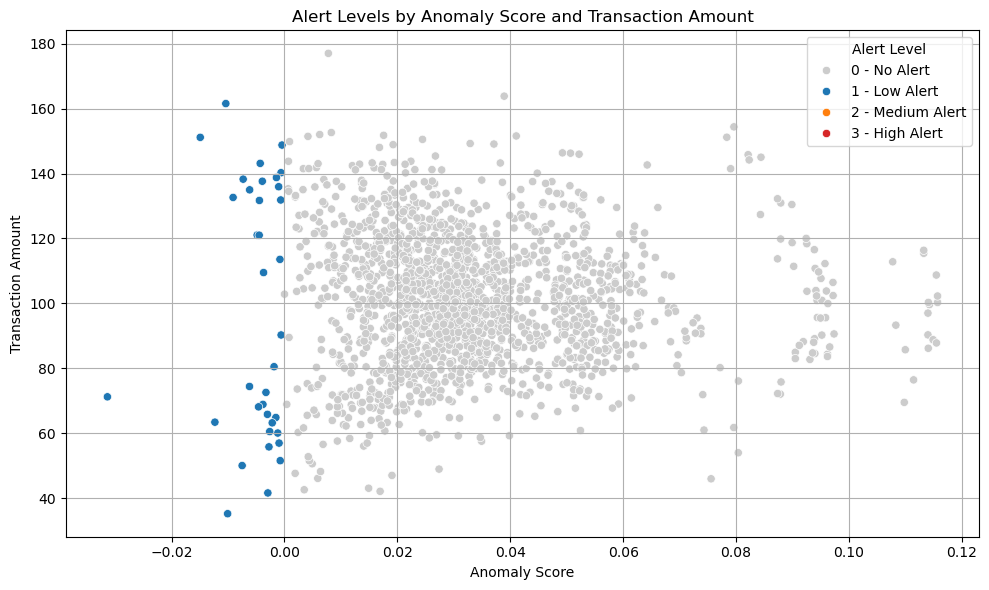

Alert scatter plot saved as 0905 alert_scatter_plot.png
Alert-level transactions saved to 0905 alert_transactions.csv


In [12]:
# Define consistent color mapping for each alert tier
custom_palette = {
    "0 - No Alert": "#cccccc",     # Gray
    "1 - Low Alert": "#1f77b4",    # Blue
    "2 - Medium Alert": "#ff7f0e", # Orange
    "3 - High Alert": "#d62728"    # Red
}

# Define fixed order of labels
alert_order = ["0 - No Alert", "1 - Low Alert", "2 - Medium Alert", "3 - High Alert"]

# Visualize and save the scatter plot (Anomaly Score vs Amount)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="AnomalyScore",
    y="TransactionAmount",
    hue="AlertLabel",
    data=df,
    palette=custom_palette,
    hue_order=alert_order
)
plt.title("Alert Levels by Anomaly Score and Transaction Amount")
plt.xlabel("Anomaly Score")
plt.ylabel("Transaction Amount")
plt.grid(True)
plt.legend(title="Alert Level")
plt.tight_layout()
plt.savefig(my_plot_file)  # Save the figure
plt.show()

# Save the alert-triggering transactions
df[df["AlertLevel"] > 0].to_csv(my_output_file, index=False)

print(f"Alert scatter plot saved as {my_plot_file}")
print(f"Alert-level transactions saved to {my_output_file}")
